### Classify an image with CaffeNet (based on AlexNet architecture)

In [1]:
# Imports
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Load **`caffe`**

In [2]:
# The caffe module needs to be on the Python path
import sys
caffe_root = '../' # Run from {caffe_root}/examples (else change)
sys.path.insert(0, caffe_root + 'python')
import caffe

Download **`CaffeNet`** (a variant of AlexNet)

In [3]:
import os
if os.path.isfile(caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print 'CaffeNet found.'
else:
    print 'Downloading pre-trained CaffeNet model...'
    !../scripts/download_model_binary.py ../models/bvlc_reference_caffenet

CaffeNet found.


**Load CaffeNet**

In [4]:
# Set Caffe to CPU mode and load the net from disk
caffe.set_mode_cpu()

# Model structure
model_def = caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
 
# Model weights
model_weights = caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'

net = caffe.Net(model_def, model_weights, caffe.TEST) # Test mode (no dropout)

**Input Processing**
- `caffe.io.Transformer`
- Custom preprocessing code 
---

CaffeNet configured to take images in BGR format. Values in range [0, 255]
- Subtract mean ImageNet pixel value
- Channel dimension: first outermost dimension
---

matplotlib loads images in range [0, 1] in RGB format with channel as innermost dimension.

In [5]:
# load the mean ImageNet image
mu = np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy')
print 'mu shape: ', mu.shape

# Average over pixels to get mean BGR pixel values
mu = mu.mean(1).mean(1)
print 'Mean-subtracted values: ', zip('BGR', mu)

mu shape:  (3, 256, 256)
Mean-subtracted values:  [('B', 104.0069879317889), ('G', 116.66876761696767), ('R', 122.6789143406786)]


In [7]:
# Create transformer for the input called 'data'
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})

# Move image channels to outer dimension, i.e. from W x H x C to C x W x H
transformer.set_transpose('data', (2, 0, 1))

# Subtract the dataset mean value in each channel
transformer.set_mean('data', mu)

# Rescale from [0, 1] to [0, 225]
transformer.set_raw_scale('data', 225)

# Swap channels from RGB to BGR
transformer.set_channel_swap('data', (2, 1, 0))

**Classification**

In [8]:
# Set the size of the input (e.g. for different batch sizes)
net.blobs['data'].reshape(50,    # Batch size
                          3,     # 3-channel (BGR)
                          227,   # H
                          227)   # W

**Trial**

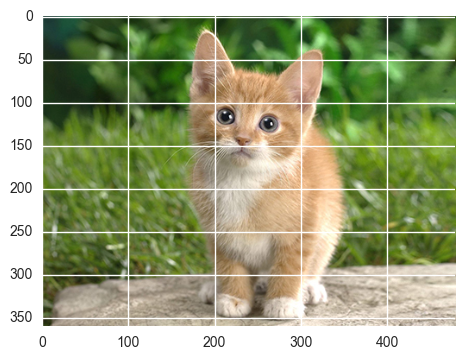

In [22]:
# Load an image and perform preprocessing
image = caffe.io.load_image(caffe_root + 'examples/images/cat.jpg')
transformed_image = transformer.preprocess('data', image)
plt.imshow(image)

Classify the transformed image

In [26]:
# Copy the transformed image data into the memory allocated for the net
net.blobs['data'].data[...] = transformed_image

# Perform classification
output = net.forward()
print 'Output shape: ', output['prob'].shape

# Output probability vector for first image in the batch
output_prob = output['prob'][0]

# Predicted class
print 'Predicted class: ', output_prob.argmax()

Output shape:  (50, 1000)
Predicted class:  281


ImageNet labels

In [30]:
# Load ImageNet labels
labels_file = caffe_root + 'data/ilsvrc12/synset_words.txt'
if not os.path.exists(labels_file):
    !../data/ilsvrc12/get_ilsvrc_aux.sh
    
labels = np.loadtxt(labels_file, str, delimiter='\t')
print 'Output label: ', labels[output_prob.argmax()]

Output label:  n02123045 tabby, tabby cat


In [43]:
# Reverse sorting example
b = np.array([10, 90, 20, 80, 30, 70, 40, 60, 50])

print b
print b.argsort()
print b.argsort()[::-1] # Reverse the sorted list
print b.argsort()[::-1][:5]

[10 90 20 80 30 70 40 60 50]
[0 2 4 6 8 7 5 3 1]
[1 3 5 7 8 6 4 2 0]
[1 3 5 7 8]


In [45]:
# Top-5 predictions
top_idxs = output_prob.argsort()[::-1][:5]
print 'Probabilities and labels: \n', zip(output_prob[top_idxs], labels[top_idxs])

Probabilities and labels: 
[(0.33238766, 'n02123045 tabby, tabby cat'), (0.25875542, 'n02123159 tiger cat'), (0.12036837, 'n02124075 Egyptian cat'), (0.078283668, 'n02127052 lynx, catamount'), (0.067682482, 'n02119022 red fox, Vulpes vulpes')]


**Intermediate Output**
- Structure of network in terms of activation (`net.blobs`) and parameter (`net.params`, `[0] for Weights and [1] for biases`]) shapes 

In [47]:
# Activation shape: (batch_size, channel_dim, height, width)
for layer_name, blob in net.blobs.iteritems():
    print layer_name + '\t' + str(blob.data.shape)

data	(50, 3, 227, 227)
conv1	(50, 96, 55, 55)
pool1	(50, 96, 27, 27)
norm1	(50, 96, 27, 27)
conv2	(50, 256, 27, 27)
pool2	(50, 256, 13, 13)
norm2	(50, 256, 13, 13)
conv3	(50, 384, 13, 13)
conv4	(50, 384, 13, 13)
conv5	(50, 256, 13, 13)
pool5	(50, 256, 6, 6)
fc6	(50, 4096)
fc7	(50, 4096)
fc8	(50, 1000)
prob	(50, 1000)


In [48]:
# Parameter shape: (output_channels, input_channels, filter_height, filter_width)
for layer_name, param in net.params.iteritems():
    W_shape = param[0].data.shape 
    b_shape = param[1].data.shape
    print layer_name + '\t' + str(W_shape) + str(b_shape)

conv1	(96, 3, 11, 11)(96,)
conv2	(256, 48, 5, 5)(256,)
conv3	(384, 256, 3, 3)(384,)
conv4	(384, 192, 3, 3)(384,)
conv5	(256, 192, 3, 3)(256,)
fc6	(4096, 9216)(4096,)
fc7	(4096, 4096)(4096,)
fc8	(1000, 4096)(1000,)


Visualizing heatmaps

In [49]:
def visualize(data):
    """
    Input: Array of shape (n, height, width) or (n, height, width, 3)
    Output: Heatmap of each (height, width) entity in a square gride of size: sqrt(n)
    """
    # Normalize data for display
    data = (data - data.min())/(data.max() - data.min())
    
    # Force number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    
    # Padding: Space between filters [Need to understand!]
    padding = (((0, n**2 - data.shape[0]),
               (0, 1), (0, 1))                # Adding space between filters
               + ((0, 0),) * (data.ndim - 3)) # Last dimension not padded
    
    data = np.pad(data, padding, mode='constant', constant_values=1) # pad with ones (white)
    
    # Tile the  filters into an image [Need to understand!]
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    plt.imshow(data)
    plt.axis('off')

Visualize First Layer Filters

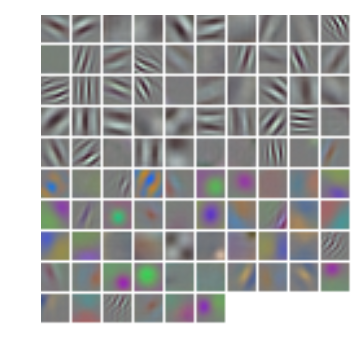

In [50]:
# Weights
filters = net.params['conv1'][0].data
visualize(filters.transpose(0, 2, 3, 1))

Visualise First Layer Outputs

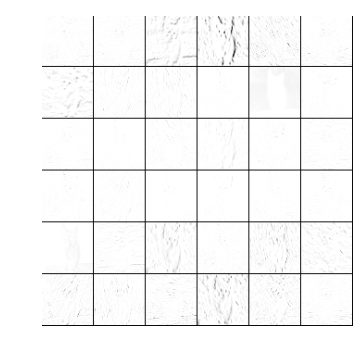

In [53]:
# Rectified responses
features = net.blobs['conv1'].data[0, :36]
visualize(features)

Visualize Fifth Layer (after pooling)

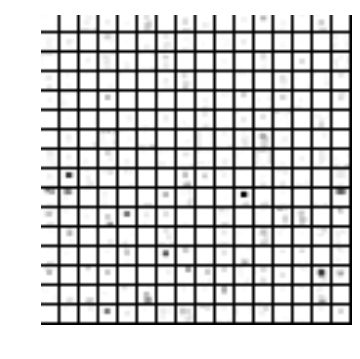

In [55]:
features = net.blobs['pool5'].data[0]
visualize(features)

First Fully Conected Layer Output

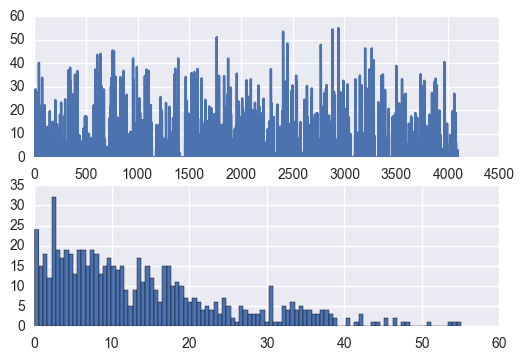

In [56]:
features = net.blobs['fc6'].data[0]
# Output values
plt.subplot(2, 1, 1)
plt.plot(features.flat)
# Histogram of positive values
plt.subplot(2, 1, 2)
_ = plt.hist(features.flat[features.flat > 0], bins=100)

Final Probability Output

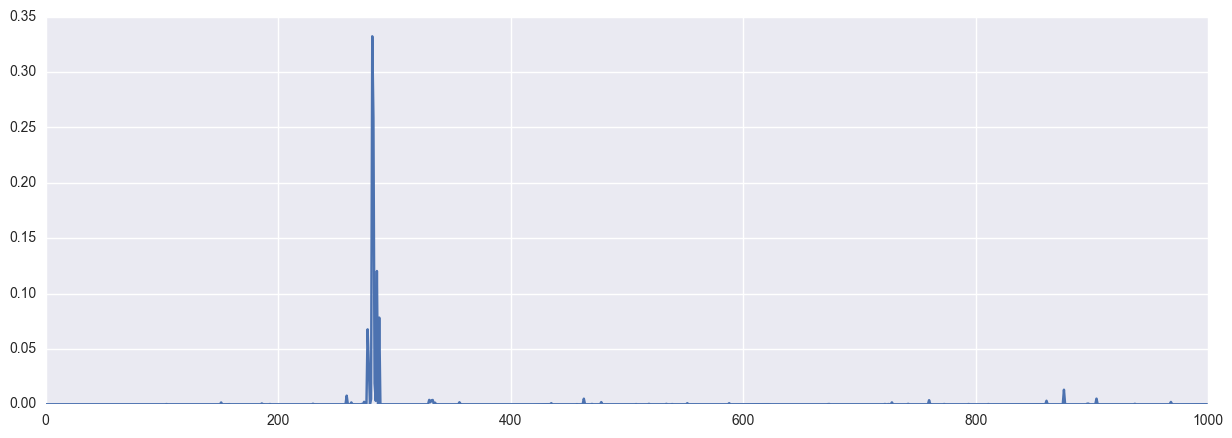

In [57]:
features = net.blobs['prob'].data[0]
plt.figure(figsize=(15, 5))
plt.plot(features.flat)

**Test on random image**

--2017-02-09 17:15:57--  http://cdn.skim.gs/images/c_fill,dpr_1.0,h_391,w_695/y5ltr2wqq3p5ut38fhdm/meet-the-breed-bernese-mountain-dog
Resolving cdn.skim.gs... 72.21.92.20
Connecting to cdn.skim.gs|72.21.92.20|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80403 (79K) [image/jpeg]
Saving to: ‘image.jpg’

image.jpg           100%[===================>]  78.52K  --.-KB/s    in 0.1s    

2017-02-09 17:15:57 (634 KB/s) - ‘image.jpg’ saved [80403/80403]

Probabilities and labels: 
[(0.8861692, 'n02107683 Bernese mountain dog'), (0.083800972, 'n02107908 Appenzeller'), (0.014750139, 'n02108000 EntleBucher'), (0.014279946, 'n02107574 Greater Swiss Mountain dog'), (0.00059622747, 'n02101006 Gordon setter')]


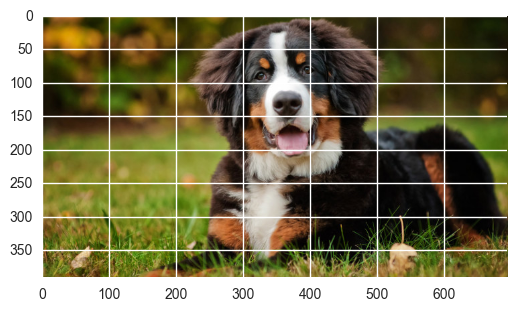

In [62]:
# Download an image
image_url = 'http://cdn.skim.gs/images/c_fill,dpr_1.0,h_391,w_695/y5ltr2wqq3p5ut38fhdm/meet-the-breed-bernese-mountain-dog'
!wget -O image.jpg $image_url

# Transform the image and copy it into the net
image = caffe.io.load_image('image.jpg')
net.blobs['data'].data[...] = transformer.preprocess('data', image)

# Classification
net.forward()

# Output Probabilities
output_prob = net.blobs['prob'].data[0]

# Top 5 predictions from softmax output
top_idxs = output_prob.argsort()[::-1][:5]

# Predictions
print 'Probabilities and labels: \n', zip(output_prob[top_idxs], labels[top_idxs])

plt.imshow(image)